# Evaluate trained models

Andrew Ashford, Pathways + Omics Group, OHSU - 5/21/2024

## Read in trained models and apply to single cell RNA-seq data

In [1]:
# Import modules
import sys
import pandas as pd
import numpy as np
import pickle
from scipy.io import mmread

# Import custom modules
sys.path.append('../')
from scOPE import preprocessing
from scOPE import utilities
from scOPE import models
from scOPE import evaluate


#### Read in and process the scRNA-seq data to use to test the model

In [2]:
# scRNA-seq data directory
data_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_D0_AML_samples_and_4_healthy_BM_samples/'

# File paths (adjust these paths as needed)
barcodes_file = data_dir + 'barcodes.tsv'
genes_file = data_dir + 'genes.tsv'
matrix_file = data_dir + 'matrix.mtx'
meta_file = data_dir + 'meta.tsv'
sc_metrics_file = data_dir + 'sc_metrics.tsv'
umap_embedding_file = data_dir + 'umap_embedding.tsv'


In [3]:
# Load barcodes
with open(barcodes_file, 'r') as f:
    barcodes = f.read().splitlines()
    
# Clean barcodes
barcodes = [barcode.strip() for barcode in barcodes if barcode.strip()]
barcodes_df = pd.DataFrame(barcodes, columns=['Barcode'])

# Load genes
with open(genes_file, 'r') as f:
    genes = f.read().splitlines()
    
# Clean genes
genes = [gene.strip() for gene in genes if gene.strip()]
genes_df = pd.DataFrame(genes, columns=['GeneName'])

# Verify lengths
print(f"Number of barcodes: {len(barcodes_df)}")
print(f"Number of genes: {len(genes_df)}")

# Load matrix
matrix = mmread(matrix_file).tocsc()

# Transpose the matrix to align dimensions
matrix = matrix.T

# Verify matrix dimensions
print(f"Matrix dimensions: {matrix.shape}")

# Ensure the lengths match
if len(barcodes_df) != matrix.shape[1]:
    raise ValueError(f"Mismatch between number of barcodes ({len(barcodes_df)}) and number of matrix columns ({matrix.shape[1]})")

if len(genes_df) != matrix.shape[0]:
    raise ValueError(f"Mismatch between number of genes ({len(genes_df)}) and number of matrix rows ({matrix.shape[0]})")

# Create the DataFrame for the gene expression data
gene_expression_df = pd.DataFrame.sparse.from_spmatrix(matrix, columns=barcodes_df['Barcode'], index=genes_df['GeneName'])


Number of barcodes: 20362
Number of genes: 18954
Matrix dimensions: (18954, 20362)


In [4]:
print(gene_expression_df)


Barcode        AML1012.D0_AAAAAGTTACGT  AML1012.D0_AAAACACCAATC  \
GeneName                                                          
A1BG                                 1                        0   
AAAS                                 0                        0   
AACS                                 0                        0   
AADAT                                0                        0   
AAED1                                0                        0   
...                                ...                      ...   
ZNF474                               0                        0   
ZNF560                               0                        0   
ZNF649-AS1                           0                        0   
ZNF660-ZNF197                        0                        0   
ZP1                                  0                        0   

Barcode        AML1012.D0_AAAATAGCCTTT  AML1012.D0_AAACATTAAACG  \
GeneName                                                     

In [5]:
# Get the expression values for TSPAN6
tspan6_data = gene_expression_df.loc["TSPAN6"]

# Filter for values greater tan 0
filtered_tspan6_data = tspan6_data[tspan6_data > 0]

# Print the filtered data
print(filtered_tspan6_data.to_string())


Barcode
AML328.D0_CTACGACAACCG     1
AML328.D0_GATTATCACGCN     1
AML328.D0_GCCCATCAGTTC     1
AML328.D0_GTTGACAAAGTT     1
AML419A.D0_CTCATAAAGATT    1
AML419A.D0_ACGACGCTGGCA    1
AML419A.D0_CTTCATATCAGC    1
AML419A.D0_TTTGATTAGCGT    1
AML419A.D0_GACTTCCATGCG    1
AML475.D0_AAGCCCACCCAG     1
AML475.D0_GGTGGCACCACN     1
AML475.D0_TTCAAACAGGTC     1
AML556.D0_ATCGCCCTTTAG     1
AML556.D0_CCGCGAATCTTT     1
AML556.D0_CCTTTTGTCACT     1
AML556.D0_GTGTTCTCTACA     2
AML556.D0_ATTAAGGTAGGG     1
AML556.D0_TTAGTCTACGAG     1
AML556.D0_CGTCGGCATTTG     2
AML556.D0_CGTTCGTCGTCG     2
AML707B.D0_ACTATTACCGCC    1
AML707B.D0_GCTACTGGATGC    1
AML707B.D0_TACACTTCTGCA    1
AML916.D0_CGAATTTTGATG     1
AML916.D0_CGGAACGTATAC     1
AML916.D0_TATCGCGCGGAN     2
AML916.D0_TTATACACCGTG     1
AML916.D0_GGGATTTGAGCN     1
AML921A.D0_ACAAGCATTCTG    1
AML921A.D0_CACGCAAGTTCT    1
AML921A.D0_CATTCATTGCGN    1
AML921A.D0_CCACGTCATTAT    1
AML921A.D0_CTAGGTTTAAGT    1
AML921A.D0_CTCATGACAGAN    1
AML921

#### Load in preprocessed bulk RNA-seq data

In [88]:
# Read in the counts df that we used to train the model since it has ENSEMBL gene IDs with another column 
# for gene names.
# Specify directory and filename of the RNA-seq counts file
counts_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'
counts_filename = 'protein_coding_genes_bulk_rna_raw_counts.txt'


In [90]:
# NOTE: This function defaults to delimiter='\t', to change this, add a delimiter= flag and specify delimiter
counts_df = preprocessing.tsv_to_df(counts_dir + counts_filename, index_col = 0)
print(counts_df)


                display_label  \
stable_id                       
ENSG00000000003        TSPAN6   
ENSG00000000005          TNMD   
ENSG00000000419          DPM1   
ENSG00000000457         SCYL3   
ENSG00000000460      C1orf112   
...                       ...   
ENSG00000273467          RPS9   
ENSG00000273469        PRPF31   
ENSG00000273470        MBOAT7   
ENSG00000273482         PRKCD   
ENSG00000273490        TSEN34   

                                                       description  \
stable_id                                                            
ENSG00000000003       tetraspanin 6 [Source:HGNC Symbol;Acc:11858]   
ENSG00000000005         tenomodulin [Source:HGNC Symbol;Acc:17757]   
ENSG00000000419  dolichyl-phosphate mannosyltransferase polypep...   
ENSG00000000457  SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...   
ENSG00000000460  chromosome 1 open reading frame 112 [Source:HG...   
...                                                            ...   
ENSG000002

In [91]:
# Iterate through the counts df used for model training and use the gene names and ensembl gene ids in order 
# to rename the single cell rna-seq data:

# Create a new dataframe to hold the result
result_df = pd.DataFrame(index=counts_df.index, columns=gene_expression_df.columns)

# Keep track of how fast we're processing these:
i = 0

# Iterate through each gene in gene_info_df
for index, row in counts_df.iterrows():
    ensembl_id = index  # Assuming index is the ENSEMBL ID
    gene_name = row['display_label']

    if i % 500 == 0:
        print('Processing ' + str(i) + ' out of ' + str(counts_df.shape[0]))
    
    if ensembl_id in gene_expression_df.index:
        result_df.loc[ensembl_id] = gene_expression_df.loc[ensembl_id]
    elif gene_name in gene_expression_df.index:
        result_df.loc[ensembl_id] = gene_expression_df.loc[gene_name]
    else:
        result_df.loc[ensembl_id] = 0
        
    i += 1

# Fill missing values with zeros
result_df.fillna(0, inplace=True)

print(result_df.head())


Processing 0 out of 22810
Processing 500 out of 22810
Processing 1000 out of 22810
Processing 1500 out of 22810
Processing 2000 out of 22810
Processing 2500 out of 22810
Processing 3000 out of 22810
Processing 3500 out of 22810
Processing 4000 out of 22810
Processing 4500 out of 22810
Processing 5000 out of 22810
Processing 5500 out of 22810
Processing 6000 out of 22810
Processing 6500 out of 22810
Processing 7000 out of 22810
Processing 7500 out of 22810
Processing 8000 out of 22810
Processing 8500 out of 22810
Processing 9000 out of 22810
Processing 9500 out of 22810
Processing 10000 out of 22810
Processing 10500 out of 22810
Processing 11000 out of 22810
Processing 11500 out of 22810
Processing 12000 out of 22810
Processing 12500 out of 22810
Processing 13000 out of 22810
Processing 13500 out of 22810
Processing 14000 out of 22810
Processing 14500 out of 22810
Processing 15000 out of 22810
Processing 15500 out of 22810
Processing 16000 out of 22810
Processing 16500 out of 22810
Proc

In [92]:
print(result_df)


Barcode         AML1012.D0_AAAAAGTTACGT AML1012.D0_AAAACACCAATC  \
stable_id                                                         
ENSG00000000003                       0                       0   
ENSG00000000005                       0                       0   
ENSG00000000419                       0                       0   
ENSG00000000457                       0                       0   
ENSG00000000460                       0                       0   
...                                 ...                     ...   
ENSG00000273467                       0                       0   
ENSG00000273469                       0                       0   
ENSG00000273470                       0                       0   
ENSG00000273482                       0                       0   
ENSG00000273490                       0                       0   

Barcode         AML1012.D0_AAAATAGCCTTT AML1012.D0_AAACATTAAACG  \
stable_id                                                    

In [12]:
# Maybe can try the following to speed up the previous code to make the scRNA-seq data in the same format
# as the bulk RNA-seq data.

'''
import pandas as pd

# Assuming counts_df and gene_expression_df are already defined
# counts_df has gene names and ensembl gene ids
# gene_expression_df has single-cell RNA-seq data

# Create a mapping from ENSEMBL ID to gene name
ensembl_to_gene = counts_df['display_label'].to_dict()

# Create a new dataframe to hold the result, initialized with zeros
result_df = pd.DataFrame(0.0, index=counts_df.index, columns=gene_expression_df.columns)

# Find common indices directly
common_ensembl_ids = counts_df.index.intersection(gene_expression_df.index)
common_gene_names = counts_df['display_label'].intersection(gene_expression_df.index)

# Directly assign values for common ENSEMBL IDs
result_df.loc[common_ensembl_ids] = gene_expression_df.loc[common_ensembl_ids]

# Assign values for common gene names
for ensembl_id, gene_name in ensembl_to_gene.items():
    if gene_name in gene_expression_df.index and ensembl_id not in common_ensembl_ids:
        result_df.loc[ensembl_id] = gene_expression_df.loc[gene_name]

# Display the resulting dataframe
print(result_df.head())
'''


"\nimport pandas as pd\n\n# Assuming counts_df and gene_expression_df are already defined\n# counts_df has gene names and ensembl gene ids\n# gene_expression_df has single-cell RNA-seq data\n\n# Create a mapping from ENSEMBL ID to gene name\nensembl_to_gene = counts_df['display_label'].to_dict()\n\n# Create a new dataframe to hold the result, initialized with zeros\nresult_df = pd.DataFrame(0.0, index=counts_df.index, columns=gene_expression_df.columns)\n\n# Find common indices directly\ncommon_ensembl_ids = counts_df.index.intersection(gene_expression_df.index)\ncommon_gene_names = counts_df['display_label'].intersection(gene_expression_df.index)\n\n# Directly assign values for common ENSEMBL IDs\nresult_df.loc[common_ensembl_ids] = gene_expression_df.loc[common_ensembl_ids]\n\n# Assign values for common gene names\nfor ensembl_id, gene_name in ensembl_to_gene.items():\n    if gene_name in gene_expression_df.index and ensembl_id not in common_ensembl_ids:\n        result_df.loc[ensemb

In [94]:
# Specify directory to save the new DF
new_sc_df_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'

# Save the data dictionary to a pickle file for downstream analysis
with open(new_sc_df_dir + 'raw_single_cell_df_ensembl_gene_ids.pkl', 'wb') as f:
    pickle.dump(result_df, f)


#### Normalize and scale the scRNA-seq data based on the data made similar to the bulk RNA-seq data

In [95]:
# If already processed the RNA-seq data to match the bulk RNA-seq data, can start here to load the raw counts in
# in the right order

# Specify directory to save the new DF
new_sc_df_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'
    
with open(new_sc_df_dir + 'raw_single_cell_df_ensembl_gene_ids.pkl', 'rb') as f:
    gene_expression_df = pickle.load(f)
    

In [96]:
# If didn't load in the data previously and just processed it, run this
gene_expression_df = result_df


In [ ]:
# Remove outliers
# Calculate total expression counts for each cell
total_counts = gene_expression_df.sum(axis=0)

# Convert to dense format if it's sparse
total_counts_dense = total_counts.sparse.to_dense() if pd.api.types.is_sparse(total_counts) else total_counts

# Calculate mean and standard deviation of total counts
mean_counts = total_counts_dense.mean()
std_counts = total_counts_dense.std()

# Set threshold for outlier removal (e.g., 3 standard deviations from the mean)
threshold_upper = mean_counts + 3 * std_counts
threshold_lower = mean_counts - 3 * std_counts

# Identify cells to keep (not outliers)
cells_to_keep = total_counts_dense[(total_counts_dense >= threshold_lower) & (total_counts_dense <= threshold_upper)].index

# Filter the dataframe to remove outlier cells
filtered_gene_expression_df = gene_expression_df[cells_to_keep]

print("Original shape:", gene_expression_df.shape)
print("Filtered shape:", filtered_gene_expression_df.shape)

print(gene_expression_df.index)
print(gene_expression_df.columns)


In [97]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Normalize counts to CPM (Counts Per Million)
def normalize_cpm(df):
    counts_per_million = df.div(df.sum(axis=0), axis=1) * 1e6
    return counts_per_million

# Step 2: Log-transform the normalized counts
def log_transform(df):
    return np.log1p(df)

# Step 3: Scale the data
def scale_data(df):
    scaler = StandardScaler(with_mean=True)
    scaled_data = scaler.fit_transform(df.T).T  # Transpose, scale, then transpose back
    scaled_data_dense = scaled_data.toarray() if hasattr(scaled_data, 'toarray') else scaled_data  # Ensure dense format
    scaled_df = pd.DataFrame(scaled_data_dense, index=df.index, columns=df.columns)
    return scaled_df


In [98]:
# Ensure the dataframe contains only numeric values
df_numeric = gene_expression_df.apply(pd.to_numeric, errors='coerce').fillna(0)

# Ensure the index (gene IDs) is preserved
df_numeric.index = gene_expression_df.index


In [99]:
# Apply normalization, log-transformation, and scaling
normalized_df = normalize_cpm(df_numeric)
log_transformed_df = log_transform(normalized_df)
scaled_df = scale_data(log_transformed_df)
#scaled_df = log_transformed_df


In [20]:
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def scale_data(out_df, scale=True):
    if scale:
        print('Scaling data..')
        
        # Check the shape of the data
        print(f'Original data shape: {out_df.shape}')
        
        # Convert sparse DataFrame to dense if it contains sparse data types
        if any(isinstance(dtype, pd.SparseDtype) for dtype in out_df.dtypes):
            out_df = out_df.sparse.to_dense()
        
        # Ensure all columns are float64 for standard scaler to work correctly
        out_df = out_df.astype(np.float64)
        
        # Initialize the scaler
        scaler = StandardScaler(with_mean=True, with_std=True)
        
        # Fit the scaler on the data and transform
        out_df_scaled = scaler.fit_transform(out_df)
        
        # Convert the scaled data back to a DataFrame for easier verification
        out_df_scaled = pd.DataFrame(out_df_scaled, index=out_df.index, columns=out_df.columns)
        
        # Verify the scaling
        means = out_df_scaled.mean(axis=0)
        stds = out_df_scaled.std(axis=0)
        
        print(f'Scaled data mean (should be close to 0):\n{means.head()}')
        print(f'Scaled data std (should be close to 1):\n{stds.head()}')
        
        return out_df_scaled
    else:
        return out_df
'''

In [35]:
# Example usage:
# Assuming out_df is your bulk RNA-seq data in a DataFrame format
#out_df = pd.DataFrame(...)  # Your original data here


#scaled_df = scale_data(log_transformed_df, scale=True)


TypeError: scale_data() got an unexpected keyword argument 'scale'

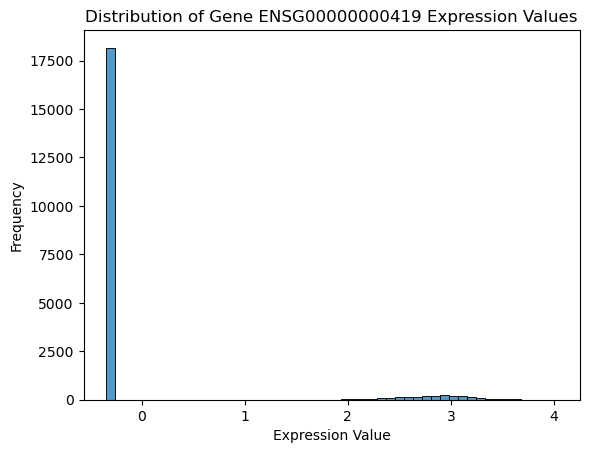

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check the distribution of values for a specific gene
#sns.histplot(scaled_df.loc['ENSG00000000419'], bins=50)
#sns.histplot(scaled_df.loc['ENSG00000000003'], bins=50)
#sns.histplot(scaled_df.loc['ENSG00000000419'], bins=50)
#sns.histplot(scaled_df.loc['ENSG00000000938'], bins=50)
sns.histplot(scaled_df.loc['ENSG00000000938'], bins=50)

plt.xlabel('Expression Value')
plt.ylabel('Frequency')
plt.title('Distribution of Gene ENSG00000000419 Expression Values')
plt.show()


In [101]:
# Assuming `scaled_df` is your DataFrame
if (scaled_df < 0).any().any():
    print("There are negative values in the DataFrame.")
else:
    print("There are no negative values in the DataFrame.")


There are negative values in the DataFrame.


In [102]:
print(scaled_df)


Barcode          AML1012.D0_AAAAAGTTACGT  AML1012.D0_AAAACACCAATC  \
stable_id                                                           
ENSG00000000003                -0.062297                -0.062297   
ENSG00000000005                 0.000000                 0.000000   
ENSG00000000419                -0.441940                -0.441940   
ENSG00000000457                -0.156836                -0.156836   
ENSG00000000460                -0.132403                -0.132403   
...                                  ...                      ...   
ENSG00000273467                 0.000000                 0.000000   
ENSG00000273469                 0.000000                 0.000000   
ENSG00000273470                 0.000000                 0.000000   
ENSG00000273482                 0.000000                 0.000000   
ENSG00000273490                 0.000000                 0.000000   

Barcode          AML1012.D0_AAAATAGCCTTT  AML1012.D0_AAACATTAAACG  \
stable_id                        

In [103]:
# Specify directory to save the new DF
new_sc_df_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'

# Save the data dictionary to a pickle file for downstream analysis
with open(new_sc_df_dir + 'normed_scaled_single_cell_df_ensembl_gene_ids.pkl', 'wb') as f:
    pickle.dump(scaled_df, f)


#### If already processed scRNA-seq data, load it in

In [104]:
new_sc_df_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'


In [105]:
# Read in the single_cell_df_ensembl_gene_ids.pkl from above
with open(new_sc_df_dir + 'normed_scaled_single_cell_df_ensembl_gene_ids.pkl', 'rb') as f:
    single_cell_data = pickle.load(f)


#### Load in trained models and classify mutations in single-cell dataframe data

In [106]:
new_sc_df_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'


In [107]:
# Specify output directory for trained model pickle files
bulk_rna_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'

# Load in the saved processed bulk RNA-seq data
with open(bulk_rna_dir + 'protein_coding_genes_bulk_rna_normed_scaled.pkl', 'rb') as f:
    processed_bulk_rna = pickle.load(f)


In [108]:
print(processed_bulk_rna)


stable_id  ENSG00000000003  ENSG00000000005  ENSG00000000419  ENSG00000000457  \
BA2392R           1.318824        -0.123395        -0.604989        -0.511886   
BA2611R           0.824273        -0.123395        -1.522052        -1.075507   
BA2506R           1.993211        -0.123395        -0.429219        -0.108360   
BA2430R           1.521140        -0.123395        -0.927872        -0.709263   
BA2448R           1.228905        -0.123395        -1.059700        -0.632505   
...                    ...              ...              ...              ...   
BA3385R          -0.322186        -0.123395        -0.014630         0.694305   
BA3242R          -0.457064        -0.123395        -0.543852         0.189898   
BA3446R          -0.389625        -0.123395         0.361747         0.505701   
BA3416R          -0.457064        -0.123395         1.001781         0.457453   
BA3123R          -0.389625        -0.123395        -0.475072         0.242532   

stable_id  ENSG00000000460 

In [110]:
# Need to transpose the bulk RNA-seq data since gene IDs are column labels..
processed_bulk_rna = processed_bulk_rna.T


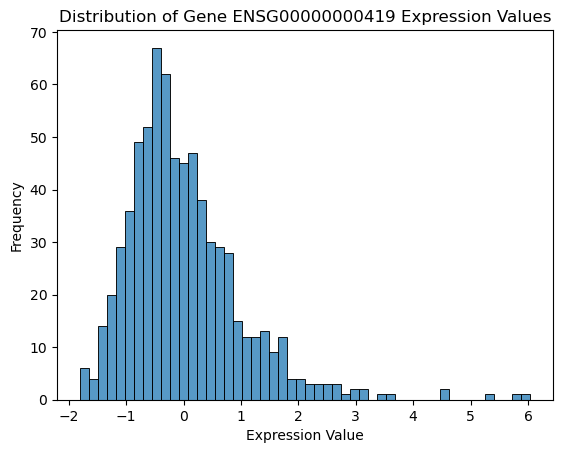

In [111]:
# Check the distribution of values for a specific gene
sns.histplot(processed_bulk_rna.loc['ENSG00000000419'], bins=50)
plt.xlabel('Expression Value')
plt.ylabel('Frequency')
plt.title('Distribution of Gene ENSG00000000419 Expression Values')
plt.show()


In [112]:
single_cell_data = scaled_df


In [113]:
print(single_cell_data)


Barcode          AML1012.D0_AAAAAGTTACGT  AML1012.D0_AAAACACCAATC  \
stable_id                                                           
ENSG00000000003                -0.062297                -0.062297   
ENSG00000000005                 0.000000                 0.000000   
ENSG00000000419                -0.441940                -0.441940   
ENSG00000000457                -0.156836                -0.156836   
ENSG00000000460                -0.132403                -0.132403   
...                                  ...                      ...   
ENSG00000273467                 0.000000                 0.000000   
ENSG00000273469                 0.000000                 0.000000   
ENSG00000273470                 0.000000                 0.000000   
ENSG00000273482                 0.000000                 0.000000   
ENSG00000273490                 0.000000                 0.000000   

Barcode          AML1012.D0_AAAATAGCCTTT  AML1012.D0_AAACATTAAACG  \
stable_id                        

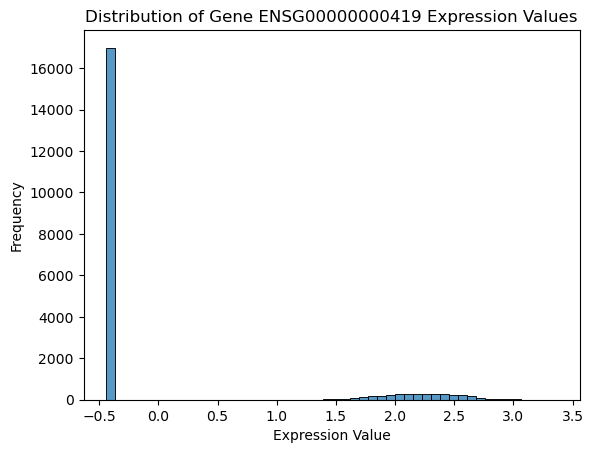

In [114]:
# Check the distribution of values for a specific gene
sns.histplot(single_cell_data.loc['ENSG00000000419'], bins=50)
plt.xlabel('Expression Value')
plt.ylabel('Frequency')
plt.title('Distribution of Gene ENSG00000000419 Expression Values')
plt.show()


#### Updating the scRNA data that's normalized and scaled to contain only the genes in the bulk RNA-seq data

In [115]:
# Find common genes
common_genes = processed_bulk_rna.index.intersection(single_cell_data.index)

# Subset the scRNA-seq dataframe to include only the common genes
single_cell_data_subset = single_cell_data.loc[common_genes]


In [116]:
# Display the subset dataframe (replace this with your preferred display method)
print(single_cell_data_subset)


Barcode          AML1012.D0_AAAAAGTTACGT  AML1012.D0_AAAACACCAATC  \
stable_id                                                           
ENSG00000000003                -0.062297                -0.062297   
ENSG00000000005                 0.000000                 0.000000   
ENSG00000000419                -0.441940                -0.441940   
ENSG00000000457                -0.156836                -0.156836   
ENSG00000000460                -0.132403                -0.132403   
...                                  ...                      ...   
ENSG00000273467                 0.000000                 0.000000   
ENSG00000273469                 0.000000                 0.000000   
ENSG00000273470                 0.000000                 0.000000   
ENSG00000273482                 0.000000                 0.000000   
ENSG00000273490                 0.000000                 0.000000   

Barcode          AML1012.D0_AAAATAGCCTTT  AML1012.D0_AAACATTAAACG  \
stable_id                        

In [117]:
# Save the single-cell data subset in a pickle file:

# Specify output directory for trained model pickle files
output_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'

# Save the data dictionary to a pickle file for downstream analysis
with open(output_dir + 'single_cell_data_protein_coding_bulk_rna_processed.pkl', 'wb') as f:
    pickle.dump(single_cell_data_subset, f)


#### Can start here to load the scRNA-seq data if already processed

In [63]:
# Load the single-cell data subset in a pickle file:

# Specify output directory for trained model pickle files
output_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'

# Load
with open(output_dir + 'single_cell_data_protein_coding_bulk_rna_processed.pkl', 'rb') as f:
    single_cell_data_subset = pickle.load(f)

In [118]:
print(single_cell_data_subset)


Barcode          AML1012.D0_AAAAAGTTACGT  AML1012.D0_AAAACACCAATC  \
stable_id                                                           
ENSG00000000003                -0.062297                -0.062297   
ENSG00000000005                 0.000000                 0.000000   
ENSG00000000419                -0.441940                -0.441940   
ENSG00000000457                -0.156836                -0.156836   
ENSG00000000460                -0.132403                -0.132403   
...                                  ...                      ...   
ENSG00000273467                 0.000000                 0.000000   
ENSG00000273469                 0.000000                 0.000000   
ENSG00000273470                 0.000000                 0.000000   
ENSG00000273482                 0.000000                 0.000000   
ENSG00000273490                 0.000000                 0.000000   

Barcode          AML1012.D0_AAAATAGCCTTT  AML1012.D0_AAACATTAAACG  \
stable_id                        

In [119]:
# Fill NA value with 0.0
single_cell_data_subset.fillna(0.0, inplace=True)


In [120]:
# Sometimes have to transpose single cell data so that the features match the training features and labels
# match the labels
#single_cell_data_subset = single_cell_data_subset.T
single_cell_data = single_cell_data.T


/tmp/ipykernel_10849/1172071659.py:22: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



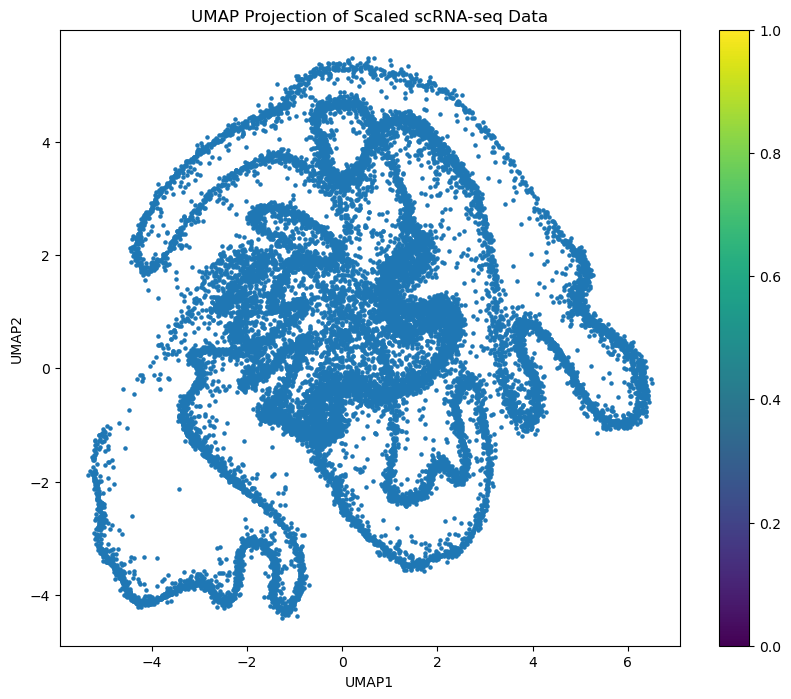

In [156]:
# Make UMAP of normalized/scaled single-cell RNA-seq data

import pandas as pd
import umap
import matplotlib.pyplot as plt

# Assuming scaled_out_df is your scaled DataFrame
# Use the DataFrame as is since 'stable_id' is the index
expression_data = single_cell_data

# Initialize the UMAP model
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')

# Fit and transform the data to get the UMAP representation
umap_embedding = reducer.fit_transform(expression_data)

# Create a DataFrame for the UMAP embedding
umap_df = pd.DataFrame(umap_embedding, index=single_cell_data.index, columns=['UMAP1', 'UMAP2'])

# Plot the UMAP representation
plt.figure(figsize=(10, 8))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], s=5, cmap='Spectral')
plt.title('UMAP Projection of Scaled scRNA-seq Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar()
plt.show()


In [121]:
# Directory containing the trained models
gene_models_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'


In [122]:
# Predict mutations in single cells
regression_predictions = evaluate.predict_mutations_in_single_cells_logistic(gene_models_dir, single_cell_data)


Predictions for SF3B1 completed.
Predictions for TET2 completed.
Predictions for PTPN11 completed.
Predictions for WT1 completed.
Predictions for U2AF1 completed.
Predictions for NF1 completed.
Predictions for GATA2 completed.
Predictions for CEBPA completed.
Predictions for DNMT3A completed.
Predictions for ASXL1 completed.
Predictions for SRSF2 completed.
Predictions for KRAS completed.
Predictions for FLT3 completed.
Predictions for IDH1 completed.
Predictions for TP53 completed.
Predictions for IDH2 completed.
Predictions for SMC3 completed.
Predictions for RUNX1 completed.
Predictions for NPM1 completed.
Predictions for EZH2 completed.
Predictions for RAD21 completed.


In [123]:
# Need to disable "summarization" to see whole np arrays
np.set_printoptions(threshold=np.inf)


In [124]:
# Print or save the predictions as needed
for gene, preds in regression_predictions.items():
    print(f"{gene}: {preds}")
    

SF3B1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

WT1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

U2AF1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

GATA2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

SRSF2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

IDH1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

SMC3: [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.

EZH2: [1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.

In [125]:
print(regression_predictions['DNMT3A'])
print(type(regression_predictions['DNMT3A']))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [126]:
# Save the predictions made:
with open(output_dir + 'single-cell_predictions_object.pkl', 'wb') as f:
    pickle.dump(regression_predictions, f)


In [127]:
print(single_cell_data_subset.columns)


Index(['AML1012.D0_AAAAAGTTACGT', 'AML1012.D0_AAAACACCAATC',
       'AML1012.D0_AAAATAGCCTTT', 'AML1012.D0_AAACATTAAACG',
       'AML1012.D0_AAACCACGTGCN', 'AML1012.D0_AAACGCTGGAAN',
       'AML1012.D0_AAACTGGTACTA', 'AML1012.D0_AAACTTGCCCGT',
       'AML1012.D0_AAATGAAAGTCC', 'AML1012.D0_AAATGTACGGTA',
       ...
       'BM4_ATACAGTAGAGC', 'BM4_CAAGAAGGAGAN', 'BM4_CGTTTAGCAGTC',
       'BM4_GAAGTTCTTGAG', 'BM4_GCCCAAATCGCT', 'BM4_GTCTCTGTTGTN',
       'BM4_TAAACGGTGCCC', 'BM4_TGGGAAAGACGN', 'BM4_TTCGGCAACCAC',
       'BM4_TTCTGCTTGCCT'],
      dtype='object', name='Barcode', length=20362)


In [130]:
# Might need to transpose:
single_cell_data_subset = single_cell_data_subset.T

regression_predictions_df = pd.DataFrame(regression_predictions)
regression_predictions_df.index = list(single_cell_data_subset.columns)


In [131]:
print(regression_predictions_df)


                         SF3B1  TET2  PTPN11  WT1  U2AF1  NF1  GATA2  CEBPA  \
AML1012.D0_AAAAAGTTACGT    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML1012.D0_AAAACACCAATC    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML1012.D0_AAAATAGCCTTT    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML1012.D0_AAACATTAAACG    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML1012.D0_AAACCACGTGCN    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
...                        ...   ...     ...  ...    ...  ...    ...    ...   
BM4_GTCTCTGTTGTN           0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
BM4_TAAACGGTGCCC           0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
BM4_TGGGAAAGACGN           0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
BM4_TTCGGCAACCAC           0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
BM4_TTCTGCTTGCCT           0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   

                         DNMT3A  ASXL1  ...  KRAS  

In [150]:
#patient = 'AML210A'
#patient = 'AML328'
#patient = 'AML1012'
#patient = 'AML419A'
#patient = 'AML921A'
#patient = 'AML707B'
patient = 'AML916'

#patient = 'BM'
#patient = 'AML'

# Filter rows where index contains the patient string variable
regression_filtered_df = regression_predictions_df[regression_predictions_df.index.str.contains(patient)]

# Print the filtered DataFrame
print(regression_filtered_df.shape)
print(regression_filtered_df)


(933, 21)
                        SF3B1  TET2  PTPN11  WT1  U2AF1  NF1  GATA2  CEBPA  \
AML916.D0_AAAAATTTCCCN    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML916.D0_AAAATATTACCT    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML916.D0_AAACCCCCCCAC    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML916.D0_AAACGATCGAAC    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML916.D0_AAAGAGAGCCCT    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
...                       ...   ...     ...  ...    ...  ...    ...    ...   
AML916.D0_CAAGTCTTCACN    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML916.D0_CCGAACCACGCA    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML916.D0_CTACATACATAA    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML916.D0_TAACACATTTCA    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   
AML916.D0_TTGTCCAGTACN    0.0   0.0     0.0  0.0    0.0  0.0    0.0    0.0   

                        DNMT3A  ASXL1  ...  KRAS  FLT

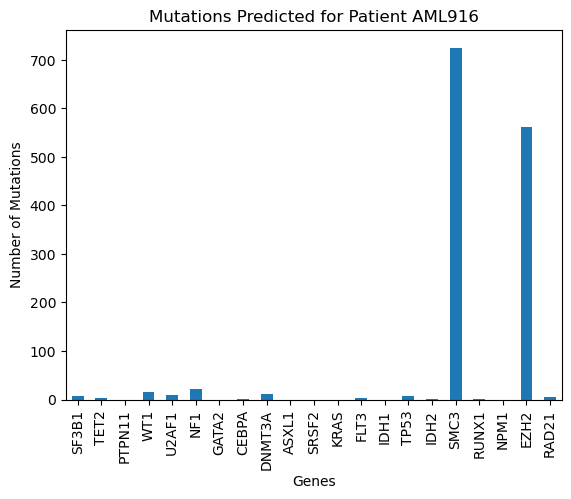

In [151]:
import matplotlib.pyplot as plt

# Filter rows where any mutation is predicted (value is 1.0)
predicted_mutations = regression_filtered_df[regression_filtered_df == 1.0].dropna(how='all', axis=0)

# Sum the number of mutations for each gene
mutation_counts = predicted_mutations.sum()

# Plot the histogram
mutation_counts.plot(kind='bar')
plt.xlabel('Genes')
plt.ylabel('Number of Mutations')
plt.title('Mutations Predicted for Patient ' + patient)
plt.show()


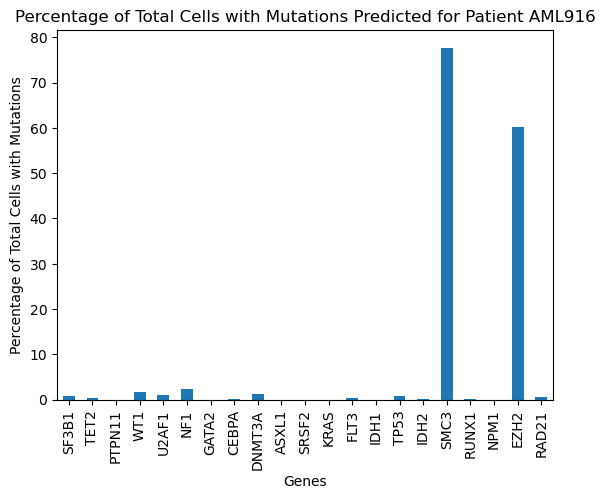

In [152]:
# Total number of cells
total_cells = regression_filtered_df.shape[0]

# Filter rows where any mutation is predicted (value is 1.0)
predicted_mutations = regression_filtered_df[regression_filtered_df == 1.0].dropna(how='all', axis=0)

# Sum the number of cells with mutations for each gene
mutation_counts = predicted_mutations.count()

# Calculate the percentage of total cells with mutations for each gene
mutation_percentages = (mutation_counts / total_cells) * 100

# Plot the histogram
mutation_percentages.plot(kind='bar')
plt.xlabel('Genes')
plt.ylabel('Percentage of Total Cells with Mutations')
plt.title('Percentage of Total Cells with Mutations Predicted for Patient ' + patient)
plt.show()


In [149]:
print(mutation_percentages)


SF3B1      0.000000
TET2       1.069519
PTPN11     0.802139
WT1        0.267380
U2AF1      0.000000
NF1        0.802139
GATA2      0.267380
CEBPA      0.401070
DNMT3A    26.604278
ASXL1      0.000000
SRSF2      0.133690
KRAS       0.000000
FLT3       1.069519
IDH1       0.000000
TP53       0.000000
IDH2       1.336898
SMC3      68.582888
RUNX1      0.000000
NPM1       0.000000
EZH2      72.994652
RAD21      0.000000
dtype: float64


In [136]:
import pandas as pd
import numpy as np
import pickle
import os
import plotly.express as px
import plotly.graph_objects as go


def plot_mutation_counts(predictions_dict, single_cell_data):
    '''
    Plots the number of positive mutations predicted for each cell.
    
    Parameters:
    - predictions_dict: Dictionary with gene names as keys and prediction arrays as values.
    - single_cell_data: DataFrame containing the single-cell RNA-seq data.
    '''
    
    # Initialize a DataFrame to store the counts of positive predictions per cell
    cell_mutation_counts = pd.DataFrame(index=single_cell_data.columns)
    
    for gene, predictions in predictions_dict.items():
        cell_mutation_counts[gene] = predictions
    
    # Calculate the number of positive predictions for each cell
    cell_mutation_counts['Positive_Mutations'] = cell_mutation_counts.sum(axis=1)
    
    # Plot the counts using Plotly for interactivity
    fig = px.bar(cell_mutation_counts, x=cell_mutation_counts.index, y='Positive_Mutations', 
                 title='Number of Positive Mutations Predicted for Each Cell',
                 labels={'index': 'Cell Barcode', 'Positive_Mutations': 'Number of Positive Mutations'},
                 color_discrete_sequence=['rgba(31, 300, 250, 3)'])  # Set darker color here
    
    fig.update_layout(xaxis={'categoryorder':'total descending'})
    fig.show()
    


In [137]:
# Plot the mutation counts for each cell
plot_mutation_counts(regression_predictions_df, single_cell_data_subset)



KeyboardInterrupt



In [48]:
single_cell_data_subset = single_cell_data_subset.T


In [49]:
# Predict mutations in single cells
random_forest_predictions = evaluate.predict_mutations_in_single_cells_logistic(gene_models_dir, single_cell_data_subset)


Predictions for SF3B1 completed.
Predictions for TET2 completed.
Predictions for PTPN11 completed.
Predictions for WT1 completed.
Predictions for U2AF1 completed.
Predictions for NF1 completed.
Predictions for GATA2 completed.
Predictions for NRAS completed.
Predictions for CEBPA completed.
Predictions for DNMT3A completed.
Predictions for ZRSR2 completed.
Predictions for KIT completed.
Predictions for ASXL1 completed.
Predictions for SRSF2 completed.
Predictions for KRAS completed.
Predictions for FLT3 completed.
Predictions for IDH1 completed.
Predictions for STAG2 completed.
Predictions for BCORL1 completed.
Predictions for TP53 completed.
Predictions for BCOR completed.
Predictions for IDH2 completed.
Predictions for SMC3 completed.
Predictions for PHF6 completed.
Predictions for RUNX1 completed.
Predictions for NPM1 completed.
Predictions for RAD21 completed.


In [50]:
# Print or save the predictions as needed
for gene, preds in random_forest_predictions.items():
    print(f"{gene}: {preds}")

print(random_forest_predictions['DNMT3A'])
print(type(random_forest_predictions['DNMT3A']))


SF3B1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

PTPN11: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

WT1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

NF1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

CEBPA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

KIT: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 

KRAS: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.

IDH1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

TP53: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

SMC3: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

NPM1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.

In [52]:
# Save the predictions made:
with open(output_dir + 'single-cell_random_forest_predictions_object.pkl', 'wb') as f:
    pickle.dump(random_forest_predictions, f)
    

In [53]:
print(single_cell_data_subset.shape)
print(single_cell_data_subset)


(20362, 15520)
stable_id                ENSG00000000003  ENSG00000000419  ENSG00000000457  \
Barcode                                                                      
AML1012.D0_AAAAAGTTACGT        -0.062305         -0.44195        -0.156839   
AML1012.D0_AAAACACCAATC        -0.062305         -0.44195        -0.156839   
AML1012.D0_AAAATAGCCTTT        -0.062305         -0.44195        -0.156839   
AML1012.D0_AAACATTAAACG        -0.062305         -0.44195        -0.156839   
AML1012.D0_AAACCACGTGCN        -0.062305         -0.44195        -0.156839   
...                                  ...              ...              ...   
BM4_GTCTCTGTTGTN               -0.062305         -0.44195        -0.156839   
BM4_TAAACGGTGCCC               -0.062305         -0.44195        -0.156839   
BM4_TGGGAAAGACGN               -0.062305         -0.44195        -0.156839   
BM4_TTCGGCAACCAC               -0.062305         -0.44195        -0.156839   
BM4_TTCTGCTTGCCT               -0.062305         

In [55]:
# Might need to transpose single-cell data subset
single_cell_data_subset = single_cell_data_subset.T


In [56]:
random_forest_predictions_df = pd.DataFrame(random_forest_predictions)
random_forest_predictions_df.index = list(single_cell_data_subset.columns)
#random_forest_predictions_df.index = list(single_cell_data_subset.values)


print(random_forest_predictions_df)


                         SF3B1  TET2  PTPN11  WT1  U2AF1  NF1  GATA2  NRAS  \
AML1012.D0_AAAAAGTTACGT    0.0   0.0     0.0  0.0    0.0  0.0    0.0   0.0   
AML1012.D0_AAAACACCAATC    0.0   0.0     0.0  0.0    0.0  0.0    0.0   0.0   
AML1012.D0_AAAATAGCCTTT    0.0   0.0     0.0  0.0    0.0  0.0    0.0   0.0   
AML1012.D0_AAACATTAAACG    0.0   0.0     0.0  0.0    0.0  0.0    0.0   0.0   
AML1012.D0_AAACCACGTGCN    0.0   0.0     0.0  0.0    0.0  0.0    1.0   0.0   
...                        ...   ...     ...  ...    ...  ...    ...   ...   
BM4_GTCTCTGTTGTN           0.0   0.0     0.0  0.0    0.0  0.0    0.0   0.0   
BM4_TAAACGGTGCCC           0.0   0.0     0.0  0.0    0.0  0.0    0.0   0.0   
BM4_TGGGAAAGACGN           0.0   0.0     0.0  0.0    0.0  0.0    0.0   1.0   
BM4_TTCGGCAACCAC           0.0   0.0     0.0  0.0    0.0  0.0    0.0   0.0   
BM4_TTCTGCTTGCCT           0.0   0.0     0.0  0.0    0.0  0.0    0.0   0.0   

                         CEBPA  DNMT3A  ...  STAG2  BCORL1  TP5

In [57]:
#patient = 'AML210A'
#patient = 'AML1012'
#patient = 'AML870'

#patient = 'BM'
patient = 'AML'

# Filter rows where index contains the string 'match'
random_forest_filtered_df = random_forest_predictions_df[random_forest_predictions_df.index.str.contains(patient)]

# Print the filtered DataFrame
print(random_forest_filtered_df.shape)


(15685, 27)


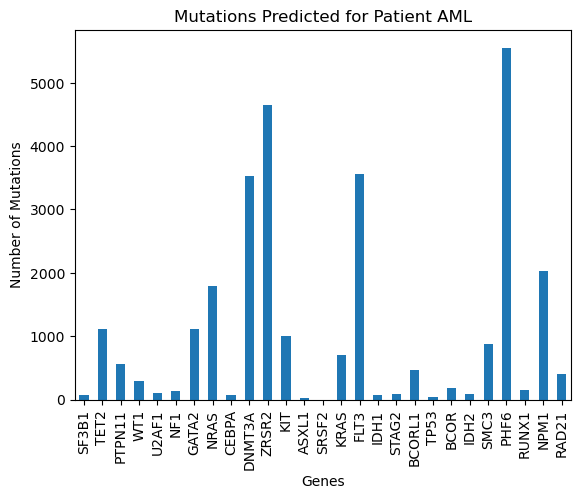

In [58]:
# Filter rows where any mutation is predicted (value is 1.0)
predicted_mutations = random_forest_filtered_df[random_forest_filtered_df == 1.0].dropna(how='all', axis=0)

# Sum the number of mutations for each gene
mutation_counts = predicted_mutations.sum()

# Plot the histogram
mutation_counts.plot(kind='bar')
plt.xlabel('Genes')
plt.ylabel('Number of Mutations')
plt.title('Mutations Predicted for Patient ' + patient)
plt.show()


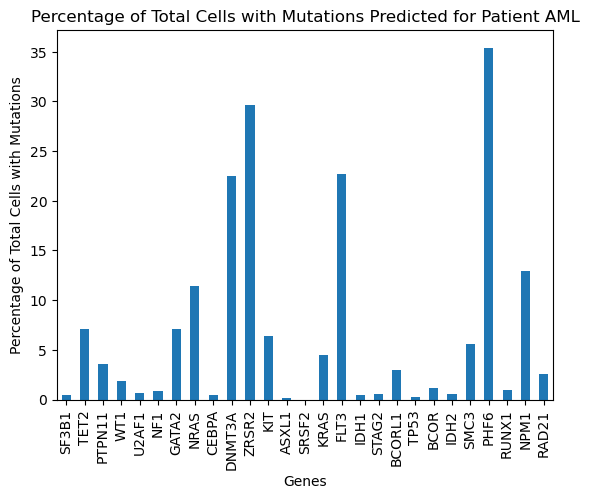

In [59]:
# Total number of cells
total_cells = random_forest_filtered_df.shape[0]

# Filter rows where any mutation is predicted (value is 1.0)
predicted_mutations = random_forest_filtered_df[random_forest_filtered_df == 1.0].dropna(how='all', axis=0)

# Sum the number of cells with mutations for each gene
mutation_counts = predicted_mutations.count()

# Calculate the percentage of total cells with mutations for each gene
mutation_percentages = (mutation_counts / total_cells) * 100

# Plot the histogram
mutation_percentages.plot(kind='bar')
plt.xlabel('Genes')
plt.ylabel('Percentage of Total Cells with Mutations')
plt.title('Percentage of Total Cells with Mutations Predicted for Patient ' + patient)
plt.show()


In [60]:
# Find consensus mutation predictions
consensus_df = (regression_filtered_df == 1) & (random_forest_predictions_df == 1)
consensus_df = consensus_df.astype(int)

# Print or save the consensus dataframe
print(consensus_df)


                         SF3B1  TET2  PTPN11  WT1  U2AF1  NF1  GATA2  NRAS  \
AML1012.D0_AAAAAGTTACGT      0     0       0    0      0    0      0     0   
AML1012.D0_AAAACACCAATC      0     0       0    0      0    0      0     0   
AML1012.D0_AAAATAGCCTTT      0     0       0    0      0    0      0     0   
AML1012.D0_AAACATTAAACG      0     0       0    0      0    0      0     0   
AML1012.D0_AAACCACGTGCN      0     0       0    0      0    0      1     0   
...                        ...   ...     ...  ...    ...  ...    ...   ...   
BM4_TTTTTAGTTGAG             0     0       0    0      0    0      0     0   
BM4_TTTTTATCACGG             0     0       0    0      0    0      0     0   
BM4_TTTTTATTATGN             0     0       0    0      0    0      0     0   
BM4_TTTTTGGATGTN             0     0       0    0      0    0      0     0   
BM4_TTTTTTATTATG             0     0       0    0      0    0      0     0   

                         CEBPA  DNMT3A  ...  STAG2  BCORL1  TP5

In [67]:
#patient = 'AML210A'
#patient = 'AML1012'
#patient = 'AML870'
patient = 'AML916'

#patient = 'BM'
#patient = 'AML'

# Filter rows where index contains the string 'match'
filtered_consensus_df = consensus_df[consensus_df.index.str.contains(patient)]

# Print the filtered DataFrame
print(filtered_consensus_df.shape)


(933, 27)


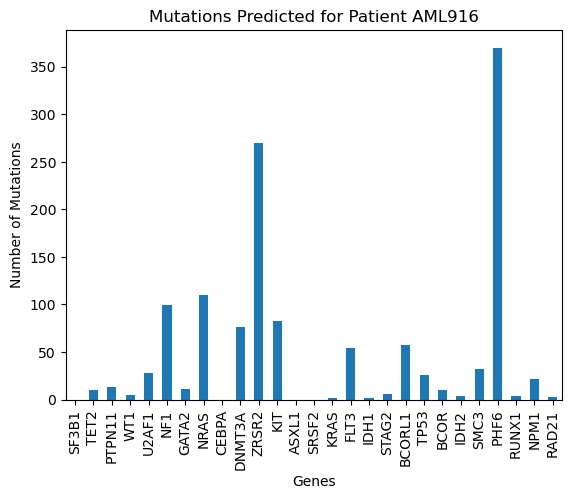

In [68]:
# Filter rows where any mutation is predicted (value is 1.0)
predicted_mutations = filtered_consensus_df[filtered_consensus_df == 1.0].dropna(how='all', axis=0)

# Sum the number of mutations for each gene
mutation_counts = predicted_mutations.sum()

# Plot the histogram
mutation_counts.plot(kind='bar')
plt.xlabel('Genes')
plt.ylabel('Number of Mutations')
plt.title('Mutations Predicted for Patient ' + patient)
plt.show()


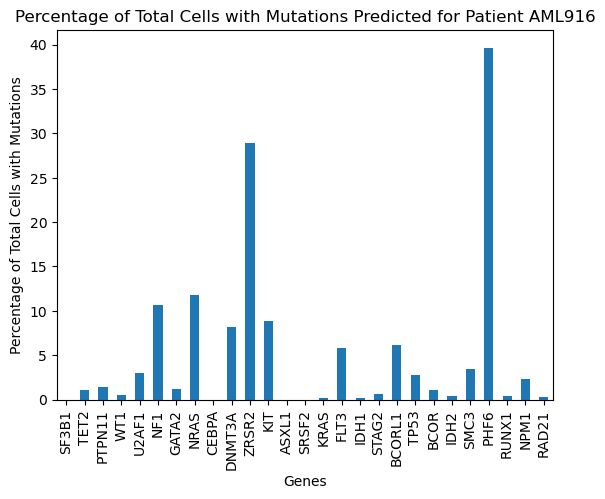

In [69]:
# Total number of cells
total_cells = filtered_consensus_df.shape[0]

# Filter rows where any mutation is predicted (value is 1.0)
predicted_mutations = filtered_consensus_df[filtered_consensus_df == 1.0].dropna(how='all', axis=0)

# Sum the number of cells with mutations for each gene
mutation_counts = predicted_mutations.count()

# Calculate the percentage of total cells with mutations for each gene
mutation_percentages = (mutation_counts / total_cells) * 100

# Plot the histogram
mutation_percentages.plot(kind='bar')
plt.xlabel('Genes')
plt.ylabel('Percentage of Total Cells with Mutations')
plt.title('Percentage of Total Cells with Mutations Predicted for Patient ' + patient)
plt.show()


In [7]:
mut_data = model_training_df_dict[gene_name]['mut_sequencing_data']

model_genes = list(mut_data.columns)

print(model_genes)


['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938', 'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084', 'ENSG00000001167', 'ENSG00000001460', 'ENSG00000001461', 'ENSG00000001497', 'ENSG00000001561', 'ENSG00000001617', 'ENSG00000001629', 'ENSG00000001630', 'ENSG00000001631', 'ENSG00000002016', 'ENSG00000002330', 'ENSG00000002549', 'ENSG00000002586', 'ENSG00000002587', 'ENSG00000002726', 'ENSG00000002822', 'ENSG00000002834', 'ENSG00000002919', 'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003096', 'ENSG00000003147', 'ENSG00000003249', 'ENSG00000003393', 'ENSG00000003400', 'ENSG00000003402', 'ENSG00000003436', 'ENSG00000003509', 'ENSG00000003756', 'ENSG00000003987', 'ENSG00000003989', 'ENSG00000004059', 'ENSG00000004139', 'ENSG00000004142', 'ENSG00000004399', 'ENSG00000004455', 'ENSG00000004468', 'ENSG00000004478', 'ENSG00000004487', 'ENSG00000004534', 'ENSG00000004660', 'ENSG00000004700', 'ENSG00000004766', 'ENSG00000004776', 'ENSG000000

In [8]:
X, y_true = utilities.get_rna_seq_data(model_training_df_dict, 'IDH1')


In [9]:
X_aligned = X[model_genes]


In [10]:
print(X)


stable_id  ENSG00000000003  ENSG00000000419  ENSG00000000457  ENSG00000000460  \
0                -0.803825         1.033155         0.627674         0.271618   
1                 0.085220        -0.633739         1.280004        -1.996500   
2                -1.804098        -0.095957         1.443502        -0.918439   
3                 1.242317         0.040606         0.463599        -0.343251   
4                 0.815787        -2.118831        -0.676210         0.744990   
..                     ...              ...              ...              ...   
85               -0.248462        -0.210078         1.221418        -0.378746   
86               -0.867542        -0.713347        -0.473854        -0.043253   
87                1.368247        -2.333660         0.528642        -0.490075   
88               -0.849957         1.296084         0.853687         0.131314   
89               -0.912341        -0.191670        -0.476620         0.517358   

stable_id  ENSG00000000938 

In [ ]:
# Retrive all the variables we need to evaluate the model:
# y_true, y_pred, y_prob, gene_name

y_true = 
y_pred = 
y_prob = 



In [ ]:
evaluate.evaluate_model(y_true, y_pred, y_prob, gene_name)
